In [18]:
%matplotlib inline

In [19]:
from enum import Enum
from math import floor, sqrt

import matplotlib.pyplot as plt
import numpy as np
import cv2

IMAGE_PATH = "resources/panda.png"
GRADIENT_THRESHOLD = 70

class PaddingMode(Enum):
    CEROS = "constant"
    REPLICA = "edge"
    SIMETRIA = "symmetric"
    CICLICO = "wrap"

In [20]:
def apply_kernel(image, kernel, post_kernel_operation):
    
    border_offset = floor(len(kernel) / 2)
    old_x_size, old_y_size = image.shape
    
    # The new image doesn't have a border and we need to account for the first and last row and columns (x2)
    new_image = np.zeros((old_x_size - (border_offset * 2), old_y_size - (border_offset * 2)), dtype=int)
    
    # Apply the kernel to each of the values
    # We need to start at the center of the kernel on the image, which is given by (boder_offset, border_offset)
    #  And end at the maximum size minus the border, with that, the output image will not have a border
    for x in range(border_offset, old_x_size - border_offset):
        for y in range(border_offset, old_y_size - border_offset):
            
            new_pixel = 0
            
            for (kernel_x, kernel_y), kernel_value in np.ndenumerate(kernel):
                old_value = image[x - border_offset + kernel_x,
                                  y - border_offset + kernel_y]
                new_pixel += old_value * kernel_value
            
            new_pixel = post_kernel_operation(new_pixel)
            
            new_x = x - border_offset
            new_y = y - border_offset
            
            new_image[new_x, new_y] = new_pixel
    return new_image

def scale_pixel_values(image, low: int = 0, high: int = 255):
    image = np.copy(image).astype("int32")
    
    min_value = np.amin(image)
    max_value = np.amax(image)
    
    image_scale_size = max_value - min_value
    reference_scale_size = high - low
    
    scale_factor = image_scale_size / reference_scale_size
    scale_factor = 1 if scale_factor == 0 else scale_factor # Avoiding dividing by zero
    
    # Use the size factor to divide all of the values in the image and floor them
    y_size, x_size = image.shape
    
    for y in range(y_size):
        for x in range(x_size):
            # First, we need to move the value to begin at the same point as low
            val = image[y][x]
            moved_val = val - min_value + low
            # Apply the floored scale factor
            image[y][x] = floor(moved_val / scale_factor)
    
    image = image.astype("int32")
    
    return image

def execute_operator(image, kernel,
                     is_convolution: bool=False,
                     padding_mode: PaddingMode = PaddingMode.CEROS,
                     post_kernel_operation = lambda pixel: pixel):
    # We are assuming the kernel will be a square with a single center, i.e. size is of odd length
    if is_convolution:
        kernel = np.rot90(kernel, k=2)
    
    # Calculate the padding
    border_offset = floor(len(kernel) / 2)
    
    # Add padding to make sure the kernel is uniformly applied
    if padding_mode == PaddingMode.CEROS:
        image = np.pad(image, pad_width=border_offset, mode=PaddingMode.CEROS.value, constant_values=0)
    else:
        image = np.pad(image, pad_width=border_offset, mode=padding_mode.value)
    
    image = image.astype("int32")
    
    new_image = apply_kernel(image, kernel, post_kernel_operation)
    
    return new_image

def combine_gradients(gx, gy, strategy):
    y_len, x_len = gx.shape
    gradient = np.zeros((y_len, x_len))
    
    # TODO: Calculate Gradient Direction Too
    for y in range(y_len):
        for x in range(x_len):
            gradient[y][x] = strategy(gx[y][x], gy[y][x])
    
    return gradient

def calculate_gradient_pythagoras(x_elm, y_elm):
    return sqrt(x_elm**2 + y_elm**2)

def convert_to_bw_gradient_image(image, threshold: int):
    new_image = np.copy(image).astype("int32")
    new_image[new_image >= threshold] = 255
    new_image[new_image != 255] = 0
    return new_image


In [21]:
panda =  cv2.cvtColor(cv2.imread(IMAGE_PATH), cv2.COLOR_BGR2RGB)

panda_grey_values = np.array(panda)

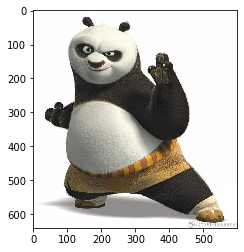

In [22]:
plt.imshow(panda)

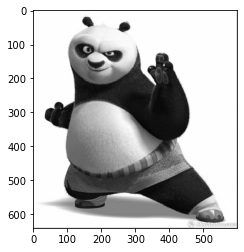

In [23]:
# Apply the greyscale by multiplying the R, G and B values of the image by the NTSC factors
panda_grey_values = np.floor(np.dot(panda_grey_values[...,:3], [0.2989, 0.5870, 0.1140]))
panda_grey_values = panda_grey_values.astype("int32")

# Apply a Gaussian kernel to reduce noice
gauss_kernel = [[2,4,5,4,2],
                [4,9,12,9,4],
                [5,12,15,12,5],
                [4,9,12,9,4],
                [2,4,5,4,2]]
panda_grey_values = execute_operator(panda_grey_values, gauss_kernel, is_convolution = True, post_kernel_operation=lambda x: x/159)
plt.imshow(panda_grey_values, cmap = plt.cm.gray)

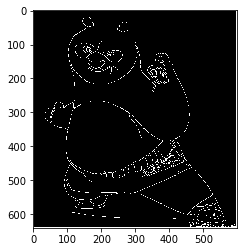

In [24]:
first_hysteresis = panda_grey_values.max() * 0.5;
second_hysteresis = first_hysteresis * 0.2;
canny_edges = cv2.Canny(np.uint8(panda_grey_values), first_hysteresis, second_hysteresis)
plt.imshow(canny_edges, cmap = plt.cm.gray)

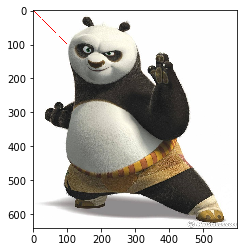

In [29]:
line_test = np.copy(panda).astype("int32")
cv2.line(line_test, (0,0), (100,100), (255,0,0), 1)
plt.imshow(line_test)